In [117]:
import torch
import pyro
import os
import torch.distributions.constraints as constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoLaplaceApproximation, AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal, AutoGuide
import pyro.optim as optim
import pyro.distributions as dist
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.poutine as poutine
pyro.set_rng_seed(101)

In [2]:
df = pd.read_csv('imaging_features_for_longcomb.csv')

# features = list(df.columns[19:124]) + list(df.columns[132:149])
features = list(df.columns[19:55]) + list(df.columns[56:92]) + list(df.columns[93:101]) + list(df.columns[103:124]) + list(df.columns[132:149])
V = len(features)
print(V, 'features')
R = df.shape[0]
print(R, 'measurements')



118 features
3309 measurements


## Statsmodels for linear mixed effects

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

predicted = []

In [277]:
batch = df['Scanner_Proxy'].unique()
batch.sort()
batches = [] #index for every observation in a scanner group

for s in batch:
    batches.append(list(df[df['Scanner_Proxy'] == s].index))
m = len(batches)
ni = [len(x) for x in batches]
L = df.shape[0]

Fit the mixed effect model:

$$ y _{ijv}(t) = \alpha_{v} + \textbf{X}_{j}^T(t)\boldsymbol{\beta}_v + \eta_{jv}
+\gamma_{iv} + \epsilon_{ijv}$$

- one model per feature
- n_subjects random effects per model
- n_scanners fixed scanner effects per model

Note: 

$\alpha$: feature mean <br>
$\textbf{X}$: covariates <br>
$\eta$: subject-specific random effect <br>
$\gamma$: scanner additive effect <br>
$\delta$: multiplicative additive effect <br>


In [5]:
# test 1 lme model

formula = "{} ~ Age + Sex + Group * Age + Scanner_Proxy".format(features[0])
print('formula: ', formula)
md = smf.mixedlm(formula, df, groups = df['Subject'])
mdf = md.fit(reml = True)
print(mdf)

formula:  lh_bankssts_thickness ~ Age + Sex + Group * Age + Scanner_Proxy


In [6]:
batch_effects = []
predicted = []
sigma_estimates = []
for i, feature in enumerate(features):
    
    formula = "{} ~ Age + Sex + Group * Age + Scanner_Proxy".format(feature)

    md = smf.mixedlm(formula, df, groups = df['Subject'])
    mdf = md.fit(reml = True)

    batchef = mdf.fe_params.filter(regex = 'Scanner') 
    pred = mdf.fittedvalues
    sig = np.sqrt(mdf.scale) #save standard deviation of residuals 
    batch_effects.append(batchef) #save scanner effects
    predicted.append(pred)
    sigma_estimates.append(sig)
    
    if i % 10 == 0:
        print(i+1, 'of', len(features), 'features done')

batch_effects = np.array(batch_effects).T
# print(mdf.summary())

1 of 118 features done
11 of 118 features done


/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


21 of 118 features done
31 of 118 features done
41 of 118 features done
51 of 118 features done


/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


61 of 118 features done
71 of 118 features done
81 of 118 features done
91 of 118 features done
101 of 118 features done
111 of 118 features done


In [7]:
#Create L x V matrix of sigma estimates
sigmas = np.tile(np.array(sigma_estimates), (df.shape[0],1))
# sigma v1 , sigma v2 , ... sigma v20
# sigma v1 , sigma v2 , ... sigma v20
# . 
# . 


#calculate gamma1hats
#weighted sum of scanner effects for each feature (weighted by #obs in feature)
gamma1hat = -np.matmul(np.expand_dims(np.array(ni[1:]), 0), batch_effects)/L

batch_effects_adjusted = batch_effects + np.tile(gamma1hat, (batch_effects.shape[0],1))
batch_effects_adjusted = np.concatenate((gamma1hat, batch_effects_adjusted), axis=0)

batch_effects_expanded = np.zeros((L,V))

for i in range(m):
    batch_effects_expanded[batches[i]] = np.tile(batch_effects_adjusted[i], (len(batches[i]),1))

Standardize:
$$ z_{ijv} = \frac{y_{ijv} - \hat{a}_v - \textbf{X}_j^T \hat{\boldsymbol{\beta}}_v - 
\hat{\eta_{jv}}}  {\hat{\sigma}_v}
$$

$$
z_{ijv} \sim Normal(\gamma_{iv}, \delta_{iv}^2)
$$

We will later sample from this to estimate every $\gamma_{iv}$ and $\delta_{iv}^2$

In [8]:
data_std= (df[features] - np.array(predicted).T + batch_effects_expanded) / sigmas
#Note: add back the batch effects

In [9]:
data_std

,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,...,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol
0,-1.547874,-0.069506,-1.847779,0.263373,-2.398496,-1.705971,-0.941493,-0.226492,-1.330728,-1.280992,...,-3.041449,-2.178495,-2.113648,-2.271082,-1.638968,-1.116800,-1.559508,-4.039776,-2.780579,-2.712960
1,-2.052939,-0.099522,-1.203332,-2.554193,-2.085419,-1.882455,-1.850814,-1.785930,-1.937982,-1.783259,...,-4.543956,-3.345620,-2.427519,-3.050804,-2.166249,-2.060648,-2.369192,-5.538674,-4.128093,-3.655408
2,-0.831753,0.262568,-1.513759,-1.550064,-1.252028,-1.324528,-1.565896,-0.645385,-1.290303,-0.335607,...,-3.651738,-2.417533,-2.078666,-2.377372,-1.957909,-1.823301,-2.123408,-4.030663,-2.981513,-3.306528
3,-0.597341,1.396936,-0.931393,-0.512975,-1.240367,-1.724851,-0.769736,-0.915249,-1.249723,-1.510702,...,-2.519039,-1.247164,-0.796648,-1.092952,-1.932177,-1.594538,-1.993537,-3.254086,-1.526423,-2.405348
4,-0.155749,0.245254,-1.391448,-0.119882,-1.407974,-1.411727,-0.737404,0.091706,-1.958065,-1.242324,...,-3.504854,-1.887398,-1.657488,-1.881854,-2.323576,-2.323018,-2.616096,-3.189102,-2.574944,-3.402323
5,-0.399171,1.647533,-2.105716,-0.812825,-1.516441,-1.696354,-1.900700,-1.075483,-0.319641,-2.972305,...,-4.346910,-2.921841,-2.902941,-3.076341,-2.480818,-1.861497,-2.475574,-3.600730,-3.860187,-4.153309
6,1.328338,2.042713,-0.367939,-0.452693,-1.092779,-0.935866,2.017520,0.855186,-1.736378,0.008278,...,-1.846902,-0.202516,-0.710079,-0.482749,-0.943947,-1.080981,-1.149920,-3.854053,-1.304952,-1.263105
7,-3.450199,-3.019993,-3.321358,-1.142936,-0.884456,-4.045823,-4.097226,-3.926508,-2.971021,-1.880608,...,-5.713681,-4.575791,-2.604126,-3.794467,-3.441634,-2.941984,-3.608498,-4.520657,-4.386409,-5.026673
8,-2.385707,0.434283,-0.954029,-0.231299,-1.381446,-0.521462,-2.729191,-0.201446,-1.675715,-1.170996,...,-2.209908,-2.009557,-2.010350,-2.119540,-0.137513,-1.214843,-0.745709,-4.650990,-2.667976,-1.932659
9,-0.228232,0.416969,-0.690163,-1.622132,-3.045855,-0.789944,0.314031,0.569211,-1.331559,-0.623999,...,-3.063030,-1.587351,-1.083742,-1.419044,-2.613720,-1.478267,-2.346422,-3.222074,-1.946117,-3.045708


## Identify priors
$\bar{\gamma}_i, \bar{\tau}^2_i,\bar{\lambda}_i, \bar{\theta}_i$

In [10]:
#Method of moments for hyperparameters priors
#gammmahat in previous parts was just used in estimation to determine the other parameters,

gammahat = np.zeros((m, V))
delta2hat = np.zeros((m, V))

Priors $\bar{\gamma}_i, \bar{\tau}^2_i$ for estimating the final additive effect
$ \gamma_{i,v} \sim N(\gamma_i, \tau^2_i)$<br>
Mean for prior: $\bar{\gamma}_i = \frac{1}{v}\sum_{v}^{} \hat{\gamma}_{iv}$<br>
Var for prior: $\bar{\tau}^2_i = \frac{1}{v - 1}\sum_{v}^{} (\bar{\gamma}_i - \hat{\gamma}_{iv})^2$

In [11]:
for i in range(m): #for every scanner
    gammahat[i] = data_std.values[batches[i],].mean(axis=0)
    delta2hat[i] = np.var(data_std.values[batches[i],], axis=0, ddof=1)

In [12]:
gammabar = gammahat.mean(axis = 1)
tau2bar = gammahat.var(axis = 1, ddof=1)

Priors $\bar{\lambda}_i, \bar{\theta}_i$ for estimating the final multiplicative effect
$ \delta^2_{i,v} \sim Inverse Gamma(\lambda_i, \theta_i)$<br>
Mean for prior $\bar{D_{i}} = \frac{1}{v}\sum_{v}^{} \hat{\delta}^2_{iv}$<br>
Var for prior: $\bar{S_{i}} = \frac{1}{v - 1}\sum_{v}^{} (\bar{\delta}^2_{iv} - D_i)^2$<br><br>
$Inverse Gamma(\bar{\lambda}_i, \bar{\theta}_i)$ has mean $\frac{\bar{\theta}_i}{\bar{\lambda}_i - 1}$ and
var $\frac{\bar{\theta}_i^2}{(\bar{\lambda}_i^2 - 1)(\bar{\lambda}_i - 2)} $<br>
$\bar{D_i} = \frac{\bar{\theta}_i}{\bar{\lambda}_i - 1}$ <br> $ \bar{S_{i}} = \frac{\bar{\theta}_i^2}{(\bar{\lambda}_i^2 - 1)(\bar{\lambda}_i - 2)}$

$\therefore \bar{\lambda}_i = \frac{\bar{D_i}^2 + 2\bar{S_i}^2}{2\bar{S_i}^2}$ <br>
and $\bar{\theta}_i = \frac{\bar{D_i}^3 + \bar{D_i}\bar{S_i}^2}{\bar{S_i}^2}$

In [13]:
dbar = delta2hat.mean(axis = 1)
S2bar = delta2hat.var(axis = 1, ddof=1)
lambdabar = (dbar**2 + 2*S2bar)/S2bar
thetabar = (dbar**3 + dbar*S2bar)/S2bar

Text(0.5, 1.0, 'gamma_iv prior for feature v = 0')

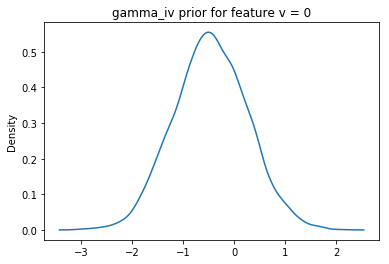

In [14]:
sns.kdeplot([pyro.distributions.Normal(gammabar[0], tau2bar[0]).sample().item() for x in range(10000)])
plt.title('gamma_iv prior for feature v = 0')

Text(0.5, 1.0, 'delta^2_iv prior for feature v=0')

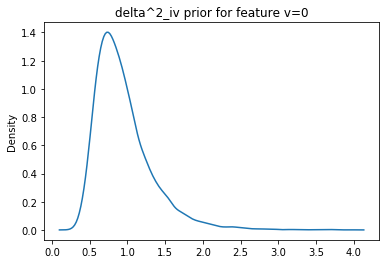

In [15]:
sns.kdeplot([pyro.distributions.InverseGamma(lambdabar[0], thetabar[0]).sample().item() for x in range(10000)])
plt.title('delta^2_iv prior for feature v=0')

In [16]:
data_std_tensor = torch.tensor(data_std.values)
data_std_tensor.shape

torch.Size([3309, 118])

## Inference With AutoDiagNormal Autoguide
Uses multivariate Normal distribution (diagonal covariance matrix) to guide over latent space

....................


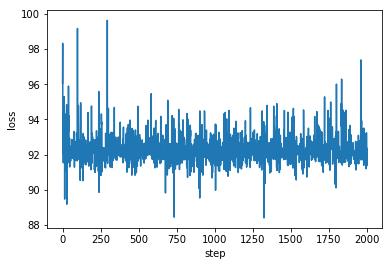

In [193]:
#Just feature 0 scanner 0
pyro.clear_param_store()
n_steps = 2000

def model(data):
    
    gamma_i0 = pyro.sample("gamma_i0", dist.Normal(torch.tensor(gammabar[0]),
                                                   torch.tensor(tau2bar[0])))
    delta2_i0 = pyro.sample("delta2_i0", dist.InverseGamma(torch.tensor(lambdabar[0]), 
                                                           torch.tensor(thetabar[0])))
    
    
    with pyro.plate("plate"):
        pyro.sample("std", dist.Normal(gamma_i0, delta2_i0), obs = data)

guide = AutoDiagonalNormal(model)

adam_params = {"lr": 0.05}
svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())

losses = []
for step in range(n_steps):
    losses.append(svi.step(data_std_tensor[batches[0],0]))
    if step % 100 == 0:
        print('.', end='')
print()

# grab the learned variational parameters

# gamma_i0 = pyro.param('AutoLaplaceApproximation.loc')[0]
# delta2_i0 = pyro.param('AutoLaplaceApproximation.loc')[1]

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss");




In [194]:
guide.quantiles([0.25,0.5,0.75])

{'gamma_i0': [tensor(0.1641, dtype=torch.float64),
  tensor(0.2486, dtype=torch.float64),
  tensor(0.3332, dtype=torch.float64)],
 'delta2_i0': [tensor(0.9950, dtype=torch.float64),
  tensor(1.0508, dtype=torch.float64),
  tensor(1.1096, dtype=torch.float64)]}

In [195]:
guide.median()

{'gamma_i0': tensor(0.2486, dtype=torch.float64),
 'delta2_i0': tensor(1.0508, dtype=torch.float64)}

In [196]:
guide()

{'gamma_i0': tensor(0.0795, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'delta2_i0': tensor(0.9971, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [215]:
def run_inf_auto(data, gammabar_prior, tau2bar_prior, lambdabar_prior, 
            thetabar_prior, n_steps = 2000, lr = .05):
    
    pyro.clear_param_store()
    
    def model(data):
        gamma_i = torch.tensor(gammabar_prior)
        tau2_i = torch.tensor(tau2bar_prior)
        lambdabar_i = torch.tensor(lambdabar_prior)
        thetabar_i = torch.tensor(thetabar_prior)

        gamma_iv = pyro.sample("gamma_iv", dist.Normal(gamma_i, tau2_i))
        delta2_iv = pyro.sample("delta2_iv", dist.InverseGamma(lambdabar_i,thetabar_i))

        with pyro.plate("plate"):
            pyro.sample("std", dist.Normal(gamma_iv, delta2_iv), obs = data)

    guide = AutoDiagonalNormal(model)

    adam_params = {"lr": lr}
    svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())

    losses = []
    for step in range(n_steps):
        losses.append(svi.step(data)) #data_std_tensor[batches[1],1]
#         if step % 100 == 0:
#             print('.', end='')
#     print()


#     plt.plot(losses)
#     plt.xlabel("step")
#     plt.ylabel("loss");


    # grab the learned variational parameters
    return guide.median()


In [216]:
scanner = 0
feature = 2
ret = run_inf_auto(data_std_tensor[batches[scanner], feature],
        gammabar[scanner], tau2bar[scanner], lambdabar[scanner], thetabar[scanner],
        n_steps=2000, lr = .005
       )
ret

{'gamma_iv': tensor(-0.1071, dtype=torch.float64),
 'delta2_iv': tensor(0.9310, dtype=torch.float64)}

In [25]:
#Inference on all scanners, all features
n_scanners = m
n_features = V
gammastarhat_final = np.zeros((n_scanners,n_features))
delta2starhat_final = np.zeros((n_scanners,n_features))
print(gammastarhat_final.shape)
for s in range(n_scanners):
    for f in range(n_features):
        params = run_inf_auto(data_std_tensor[batches[s], f],
        gammabar[s], tau2bar[s], lambdabar[s], thetabar[s],
        n_steps=500, lr = .005)
        
        gammastarhat_final[s][f] = params['gamma_iv']
        delta2starhat_final[s][f] = params['delta2_iv']
    print(s+1, 'scanners done')
        

(83, 118)
1 scanners done
2 scanners done
3 scanners done
4 scanners done
5 scanners done
6 scanners done
7 scanners done
8 scanners done
9 scanners done
10 scanners done
11 scanners done
12 scanners done
13 scanners done
14 scanners done
15 scanners done
16 scanners done
17 scanners done
18 scanners done
19 scanners done
20 scanners done
21 scanners done
22 scanners done
23 scanners done
24 scanners done
25 scanners done
26 scanners done
27 scanners done
28 scanners done
29 scanners done
30 scanners done
31 scanners done
32 scanners done
33 scanners done
34 scanners done
35 scanners done
36 scanners done
37 scanners done
38 scanners done
39 scanners done
40 scanners done
41 scanners done
42 scanners done
43 scanners done
44 scanners done
45 scanners done
46 scanners done
47 scanners done
48 scanners done
49 scanners done
50 scanners done
51 scanners done
52 scanners done
53 scanners done
54 scanners done
55 scanners done
56 scanners done
57 scanners done
58 scanners done
59 scanners d

In [140]:
gammastarhat_final

array([[ 2.84900644e-01,  8.54415911e-01, -1.01197594e-01, ...,
        -1.19942647e+00, -1.10680104e+00, -1.23375057e+00],
       [ 1.93964352e-01, -4.55705998e-01, -5.19671678e-01, ...,
        -1.84295339e+00, -2.36708179e+00, -2.14828100e+00],
       [ 1.15226418e+00,  1.21325205e-01,  8.44251641e-01, ...,
         1.56636484e+00,  1.47967699e+00,  1.38878566e+00],
       ...,
       [-9.64143035e-01,  9.22956208e-01,  1.74841476e-03, ...,
         1.76279207e+00,  3.06994543e+00, -2.73475639e-01],
       [ 1.63149402e+00, -3.51772575e-01,  1.37858961e+00, ...,
        -4.29583132e-01,  1.62286640e+00,  1.05270637e+00],
       [ 6.47821455e-01,  1.56014626e+00,  1.22669848e-02, ...,
         1.66111335e+00,  1.05077784e+00, -1.77351022e-01]])

In [141]:
delta2starhat_final

array([[1.03790288, 1.04293542, 0.95068055, ..., 0.72068764, 0.84700496,
        1.01772364],
       [0.94995184, 0.88134287, 0.75870869, ..., 0.87501964, 0.98987042,
        0.82825819],
       [1.0249147 , 0.95637508, 1.10826913, ..., 0.72301182, 1.10666331,
        1.30631832],
       ...,
       [0.87340137, 1.27614243, 0.77799105, ..., 0.86551693, 1.05229913,
        0.82777872],
       [0.85304408, 0.7240754 , 0.52909888, ..., 0.68933385, 0.47263685,
        0.96202775],
       [1.03150214, 1.5384668 , 1.2154289 , ..., 0.80817418, 1.28446914,
        1.04446666]])

In [142]:
np.save('gammastarhat_final.npy', gammastarhat_final)
np.save('delta2starhat_final.npy', delta2starhat_final)

In [229]:
gammastarhat_final_r = pd.read_csv('gammastarhat_final_r.csv', sep = ' ').values
delta2starhat_final_r = pd.read_csv('delta2starhat_final_r.csv', sep = ' ').values


In [236]:
assert(gammastarhat_final.shape == gammastarhat_final_r.shape == delta2starhat_final.shape == delta2starhat_final_r.shape)


correlation 0.7952630578287717


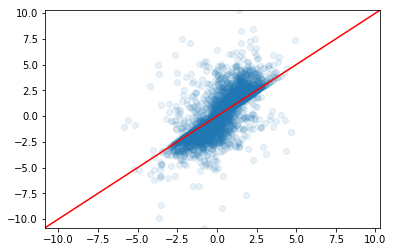

In [264]:
ma  = max(max(gammastarhat_final.flatten()), max(gammastarhat_final_r.flatten()))
mi = min(min(gammastarhat_final.flatten()), min(gammastarhat_final_r.flatten()))
plt.plot(np.linspace(mi,ma), np.linspace(mi,ma), color = 'red')
plt.ylim(mi,ma)
plt.xlim(mi,ma)
plt.scatter(gammastarhat_final, gammastarhat_final_r, alpha = .1)
print('correlation', np.corrcoef(gammastarhat_final.flatten(), gammastarhat_final_r.flatten())[1,0])

correlation: 0.63725868557634


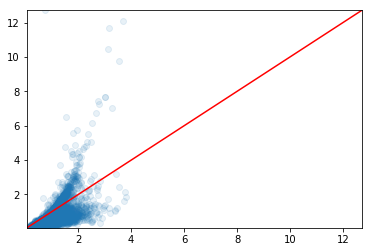

In [263]:
ma  = max(max(delta2starhat_final.flatten()), max(delta2starhat_final_r.flatten()))
mi = min(min(delta2starhat_final.flatten()), min(delta2starhat_final_r.flatten()))
plt.plot(np.linspace(0,ma), np.linspace(0,ma), color = 'red')
plt.ylim(mi,ma)
plt.xlim(mi,ma)

plt.scatter(delta2starhat_final, delta2starhat_final_r, alpha = .1)
print('correlation:', np.corrcoef(delta2starhat_final.flatten(), delta2starhat_final_r.flatten())[1,0])

The below code is just experimenting with different guides

## Try inference with AutoLaplaceApproximation
Quadratic approximation. MAP guide over unconstrained latent space

....................
gamma_i0 =  tensor(0.2715, dtype=torch.float64, grad_fn=<ExpandBackward>)
delta2_i0 =  tensor(1.0163, dtype=torch.float64, grad_fn=<ExpandBackward>)


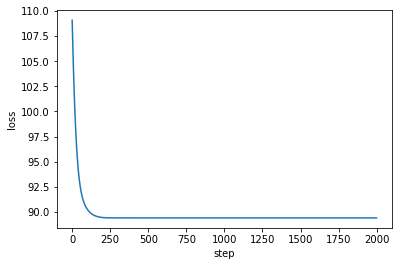

In [218]:
#Just try for scanner 0 feature 0
pyro.clear_param_store()
n_steps = 2000

def model_0(data_std_tensor):
    gamma_i = torch.tensor(gammabar[0])
    tau2_i = torch.tensor(tau2bar[0])
    lambdabar_i = torch.tensor(lambdabar[0])
    thetabar_i = torch.tensor(thetabar[0])
    
    gamma_i0 = pyro.sample("gamma_i0", dist.Normal(gamma_i, tau2_i))
    delta2_i0 = pyro.sample("delta2_i0", dist.InverseGamma(lambdabar_i, thetabar_i))
    
    
    with pyro.plate("plate"):
        pyro.sample("std", dist.Normal(gamma_i0, delta2_i0), obs = data_std_tensor[batches[0],0])

guide_0 = AutoLaplaceApproximation(model_0)

adam_params = {"lr": 0.005}
svi = SVI(model_0, guide_0, optim.Adam(adam_params), Trace_ELBO())

losses = []
gammas = []
deltas = []
for step in range(n_steps):
    losses.append(svi.step(data_std_tensor))
    gammas.append(guide_0()['gamma_i0'].item())
    deltas.append(guide_0()['delta2_i0'].item())
    if step % 100 == 0:
        print('.', end='')
print()


gamma_i0 = guide_0()['gamma_i0']
delta2_i0 = guide_0()['delta2_i0']

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss");

print('gamma_i0 = ',gamma_i0)
print('delta2_i0 = ',delta2_i0)

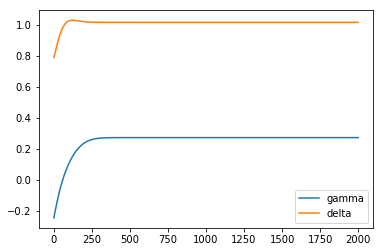

In [219]:
plt.plot(gammas, label = 'gamma')
plt.plot(deltas, label = 'delta')
plt.legend()
plt.show()

Parameter containing:
tensor([0.2715, 0.0162], dtype=torch.float64, requires_grad=True)


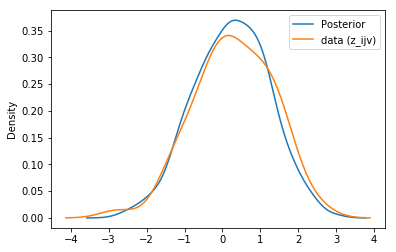

In [221]:
print(guide_0.get_posterior().mean)
sns.kdeplot([pyro.distributions.Normal(gamma_i0, delta2_i0).sample().item() for x in range(1000)], label = 'Posterior')
sns.kdeplot(data_std_tensor[batches[0],0], label = 'data (z_ijv)')
plt.legend()


In [266]:
def run_inf_auto_laplace(data, gammabar_prior, tau2bar_prior, lambdabar_prior, 
            thetabar_prior, n_steps = 2000, lr = .05):
    
    pyro.clear_param_store()
    
    def model(data):
        gamma_i = torch.tensor(gammabar_prior)
        tau2_i = torch.tensor(tau2bar_prior)
        lambdabar_i = torch.tensor(lambdabar_prior)
        thetabar_i = torch.tensor(thetabar_prior)

        gamma_iv = pyro.sample("gamma_iv", dist.Normal(gamma_i, tau2_i))
        delta2_iv = pyro.sample("delta2_iv", dist.InverseGamma(lambdabar_i,thetabar_i))

        with pyro.plate("plate"):
            pyro.sample("std", dist.Normal(gamma_iv, delta2_iv), obs = data)

    guide = AutoLaplaceApproximation(model)

    adam_params = {"lr": lr}
    svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())

    losses = []
    for step in range(n_steps):
        losses.append(svi.step(data)) #data_std_tensor[batches[1],1]
#         if step % 100 == 0:
#             print('.', end='')
#     print()


#     plt.plot(losses)
#     plt.xlabel("step")
#     plt.ylabel("loss");


    # grab the learned variational parameters
    return guide

In [273]:
scanner = 0
feature = 2
ret = run_inf_auto_laplace(data_std_tensor[batches[scanner], feature],
        gammabar[scanner], tau2bar[scanner], lambdabar[scanner], thetabar[scanner],
        n_steps=500, lr = .005
       )
ret()

{'gamma_iv': tensor(-0.1010, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'delta2_iv': tensor(0.9235, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [ ]:
#Inference on all scanners, all features
n_scanners = m
n_features = V
gammastarhat_final_al = np.zeros((n_scanners,n_features))
delta2starhat_final_al = np.zeros((n_scanners,n_features))
print(gammastarhat_final_al.shape)
for s in range(n_scanners):
    for f in range(n_features):
        g = run_inf_auto_laplace(data_std_tensor[batches[s], f],
        gammabar[s], tau2bar[s], lambdabar[s], thetabar[s],
        n_steps=500, lr = .005)
        
        gammastarhat_final_al[s][f] = g()['gamma_iv']
        delta2starhat_final_al[s][f] = g()['delta2_iv']
    print(s+1, 'scanners done')
        

(83, 118)
1 scanners done
2 scanners done
3 scanners done
4 scanners done
5 scanners done
6 scanners done
7 scanners done
8 scanners done
9 scanners done
10 scanners done
11 scanners done
12 scanners done
13 scanners done
14 scanners done
15 scanners done
16 scanners done
17 scanners done
18 scanners done
19 scanners done
20 scanners done
21 scanners done
22 scanners done
23 scanners done
24 scanners done
25 scanners done
26 scanners done
27 scanners done
28 scanners done
29 scanners done
30 scanners done
31 scanners done
32 scanners done
33 scanners done
34 scanners done
35 scanners done
36 scanners done
37 scanners done
38 scanners done
39 scanners done
40 scanners done
41 scanners done
42 scanners done
43 scanners done
44 scanners done
45 scanners done
46 scanners done
47 scanners done
48 scanners done
49 scanners done
50 scanners done
51 scanners done
52 scanners done
53 scanners done
54 scanners done
55 scanners done
56 scanners done
57 scanners done
58 scanners done
59 scanners d

In [ ]:
np.save('gammastarhat_final_al.npy', gammastarhat_final_al)
np.save('delta2starhat_final_al.npy', delta2starhat_final_al)

In [ ]:
ma  = max(max(gammastarhat_final_al.flatten()), max(gammastarhat_final_r.flatten()))
mi = min(min(gammastarhat_final_al.flatten()), min(gammastarhat_final_r.flatten()))
plt.plot(np.linspace(mi,ma), np.linspace(mi,ma), color = 'red')
plt.ylim(mi,ma)
plt.xlim(mi,ma)
plt.scatter(gammastarhat_final_al, gammastarhat_final_r, alpha = .1)
print('correlation', np.corrcoef(gammastarhat_final_al.flatten(), gammastarhat_final_r.flatten())[1,0])

In [ ]:
ma  = max(max(delta2starhat_final_al.flatten()), max(delta2starhat_final_r.flatten()))
mi = min(min(delta2starhat_final_al.flatten()), min(delta2starhat_final_r.flatten()))
plt.plot(np.linspace(0,ma), np.linspace(0,ma), color = 'red')
plt.ylim(mi,ma)
plt.xlim(mi,ma)

plt.scatter(delta2starhat_final_al, delta2starhat_final_r, alpha = .1)
print('correlation:', np.corrcoef(delta2starhat_final_al.flatten(), delta2starhat_final_r.flatten())[1,0])

## With custom guide

/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

..................................................
gamma_i_q:  0.25590334631857453
tau2_i_q:  0.13235059451044948
lambdabar_i_q:  6.480999458988558
thetabar_i_q:  7.03164067257773
Mean for gammma_i0:  0.25590334631857453
Mean for lambda_io:  1.2829121267374328



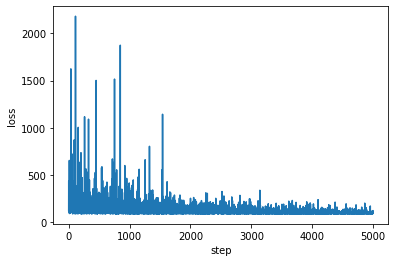

In [396]:
pyro.clear_param_store()
n_steps = 5000

def model(data):
    gamma_i = torch.tensor(gammabar[0])
    tau2_i = torch.tensor(tau2bar[0])
    lambdabar_i = torch.tensor(lambdabar[0])
    thetabar_i = torch.tensor(thetabar[0])
    
    gamma_i0 = pyro.sample("gamma_i0", dist.Normal(gamma_i, tau2_i))
    delta2_i0 = pyro.sample("delta2_i0", dist.InverseGamma(lambdabar_i,thetabar_i))
       
    with pyro.plate("plate"):
        pyro.sample("std", dist.Normal(gamma_i0, delta2_i0), obs = data)

def guide(data):
    gamma_i_q = pyro.param("gamma_i_q", torch.tensor(torch.tensor(gammabar[0])))
    tau2_i_q = pyro.param("tau2_i_q", torch.tensor(torch.tensor(tau2bar[0])), constraint = constraints.positive)
    lambdabar_i_q = pyro.param("lambdabar_i_q", torch.tensor(torch.tensor(tau2bar[0])), constraint = constraints.positive)
    thetabar_i_q = pyro.param("thetabar_i_q", torch.tensor(torch.tensor(tau2bar[0])), constraint = constraints.positive)
    
    pyro.sample("gamma_i0", dist.Normal(gamma_i_q, tau2_i_q))
    pyro.sample("delta2_i0", dist.InverseGamma(lambdabar_i_q,thetabar_i_q))
    

adam_params = {"lr": 0.005}
svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())

losses = []
for step in range(n_steps):
    losses.append(svi.step(data_std_tensor[batches[0],0]))
    if step % 100 == 0:
        print('.', end='')
print()

# grab the learned variational parameters

# gamma_i0 = pyro.param('AutoLaplaceApproximation.loc')[0]
# delta2_i0 = pyro.param('AutoLaplaceApproximation.loc')[1]

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss");


gamma_i_q = pyro.param("gamma_i_q").item()
tau2_i_q = pyro.param("tau2_i_q").item()
lambdabar_i_q = pyro.param("lambdabar_i_q").item()
thetabar_i_q = pyro.param("thetabar_i_q").item()

print("gamma_i_q: ", gamma_i_q)
print("tau2_i_q: ", tau2_i_q)
print("lambdabar_i_q: ", lambdabar_i_q)
print("thetabar_i_q: ", thetabar_i_q)

print('Mean for gammma_i0: ', gamma_i_q)
print('Mean for lambda_io: ', thetabar_i_q/(lambdabar_i_q-1))

print()

In [413]:
def run_inf(data, gammabar_prior, tau2bar_prior, lambdabar_prior, 
            thetabar_prior, n_steps = 2000, lr = .05):
    
    pyro.clear_param_store()
    
    def model(data):
        gamma_i = torch.tensor(gammabar_prior)
        tau2_i = torch.tensor(tau2bar_prior)
        lambdabar_i = torch.tensor(lambdabar_prior)
        thetabar_i = torch.tensor(thetabar_prior)

        gamma_iv = pyro.sample("gamma_iv", dist.Normal(gamma_i, tau2_i))
        delta2_iv = pyro.sample("delta2_iv", dist.InverseGamma(lambdabar_i,thetabar_i))

        with pyro.plate("plate"):
            pyro.sample("std", dist.Normal(gamma_iv, delta2_iv), obs = data)

    def guide(data):
        gamma_i_q = pyro.param("gamma_i_q", torch.tensor(gammabar_prior))
        tau2_i_q = pyro.param("tau2_i_q", torch.tensor(tau2bar_prior), constraint = constraints.positive)
        lambdabar_i_q = pyro.param("lambdabar_i_q", torch.tensor(lambdabar_prior), constraint = constraints.positive)
        thetabar_i_q = pyro.param("thetabar_i_q", torch.tensor(thetabar_prior), constraint = constraints.positive)

        pyro.sample("gamma_iv", dist.Normal(gamma_i_q, tau2_i_q))
        pyro.sample("delta2_iv", dist.InverseGamma(lambdabar_i_q,thetabar_i_q))


    adam_params = {"lr": lr}
    svi = SVI(model, guide, optim.Adam(adam_params), Trace_ELBO())

    losses = []
    for step in range(n_steps):
        losses.append(svi.step(data)) #data_std_tensor[batches[1],1]
        if step % 100 == 0:
            print('.', end='')
    print()


    plt.plot(losses)
    plt.xlabel("step")
    plt.ylabel("loss");


    gamma_i_q = pyro.param("gamma_i_q").item()
    tau2_i_q = pyro.param("tau2_i_q").item()
    lambdabar_i_q = pyro.param("lambdabar_i_q").item()
    thetabar_i_q = pyro.param("thetabar_i_q").item()

    print("gamma_i_q: ", gamma_i_q, end = ' ')
    print("tau2_i_q: ", tau2_i_q, end=' ')
    print("lambdabar_i_q: ", lambdabar_i_q, end=' ')
    print("thetabar_i_q: ", thetabar_i_q)

    print('Mean for gammma_iv: ', gamma_i_q)
    print('Mean for lambda_iv: ', thetabar_i_q/(lambdabar_i_q-1))
    
    return gamma_i_q, tau2_i_q, lambdabar_i_q, thetabar_i_q


....................
gamma_i_q:  0.4958876591115383 tau2_i_q:  0.2804748558447396 lambdabar_i_q:  5.358993621416393 thetabar_i_q:  2.755530021037794
Mean for gammma_iv:  0.4958876591115383
Mean for lambda_iv:  0.632148211343889


(0.4958876591115383, 0.2804748558447396, 5.358993621416393, 2.755530021037794)

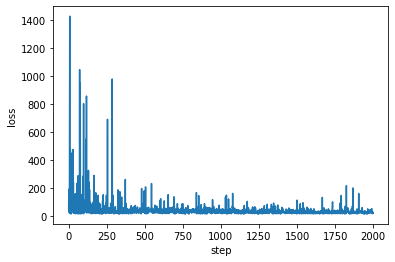

In [421]:
scanner = 3
feature = 0
run_inf(data_std_tensor[batches[scanner], feature],
        gammabar[scanner], tau2bar[scanner], lambdabar[scanner], thetabar[scanner],
        n_steps=2000, lr = .005
       )

....................................................................................................
gamma_i_q:  0.09369298466291559 tau2_i_q:  0.10125371593525757 lambdabar_i_q:  50.093575541602206 thetabar_i_q:  40.553708208694104
Mean for gammma_iv:  0.09369298466291559
Mean for lambda_iv:  0.82604918792946


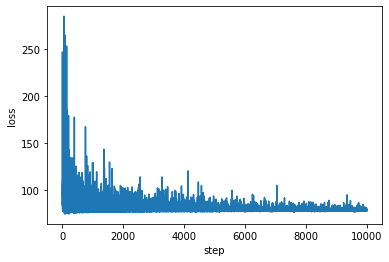

In [477]:
scanner = 0
feature = 3
g,t,l,th = run_inf(data_std_tensor[batches[scanner], feature],
        gammabar[scanner], tau2bar[scanner], lambdabar[scanner], thetabar[scanner],
        n_steps=10000, lr = .005
       )

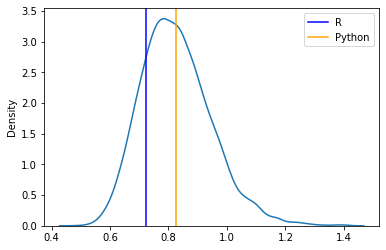

In [478]:
sns.kdeplot([pyro.distributions.InverseGamma(l,th).sample().item() for x in range(10000)])
plt.axvline(x=0.7241907, label = 'R', color='blue')
plt.axvline(x=th/(l-1), label = 'Python', color = 'orange')
plt.legend()

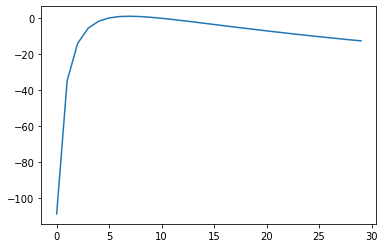

In [449]:
plt.plot(pyro.distributions.InverseGamma(l,th).log_prob(torch.tensor(np.linspace(0.1,3,30))))